In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader

import neuromancer as nm
from neuromancer.dataset import DictDataset

import lightning.pytorch as pl 
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import Dataset, DataLoader

num_vars = 2
# expected returns
exp_returns = np.random.uniform(0.002, 0.01, num_vars)
print("Expected Returns:")
print(exp_returns)
# covariance matrix
A = np.random.rand(num_vars, num_vars)
# positive semi-definite matrix
cov_matrix = A @ A.T / 1000
print("Covariance Matrix:")
print(cov_matrix)

# generate data
p_low, p_high = max(min(exp_returns),0), max(exp_returns)
data_train = DictDataset({"p": torch.FloatTensor(1000, 1).uniform_(p_low, p_high)})
data_test = DictDataset({"p": torch.FloatTensor(100, 1).uniform_(p_low, p_high)})
data_dev = DictDataset({"p": torch.FloatTensor(100, 1).uniform_(p_low, p_high)})

def data_setup_function(exp_returns): 
    p_low, p_high = max(min(exp_returns),0), max(exp_returns)
    data_train = DictDataset({"p": torch.FloatTensor(1000, 1).uniform_(p_low, p_high)})
    data_test = DictDataset({"p": torch.FloatTensor(100, 1).uniform_(p_low, p_high)})
    data_dev = DictDataset({"p": torch.FloatTensor(100, 1).uniform_(p_low, p_high)})
    return data_train, data_dev, data_test



Expected Returns:
[0.00604818 0.00572572]
Covariance Matrix:
[[0.0006422  0.0005215 ]
 [0.0005215  0.00043878]]


x

In [2]:

# parameters
p = nm.constraint.variable("p")
# variables
x = nm.constraint.variable("x")

# objective function
# Reshape x to (num_samples, num_vars, 1)
f = sum(cov_matrix[i, j] * x[:, i] * x[:, j] for i in range(num_vars) for j in range(num_vars))


obj = [f.minimize(weight=1.0, name="obj")]

# constraints
constrs = []
# constr: 100 units
con = 100 * (sum(x[:, i] for i in range(num_vars)) == 1)
con.name = "c_units"
constrs.append(con)
# constr: expected return
con = 100 * (sum(exp_returns[i] * x[:, i] for i in range(num_vars)) >= p[:, 0])
con.name = "c_return"
constrs.append(con)

# define neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=1, outsize=num_vars, bias=True,
                             linear_map=nm.slim.maps["linear"], nonlin=nn.ReLU, hsizes=[5]*4)
# solution map from model parameters: sol_map(p) -> x
sol_map = nm.system.Node(func, ["p"], ["x"], name="smap")
# trainable components
components = [sol_map]

# merit loss function
loss = nm.loss.PenaltyLoss(obj, constrs)
# problem
problem = nm.problem.Problem(components, loss)

# training
lr = 0.001  # step size for gradient descent
epochs = 20  # number of training epochs
warmup = 50  # number of epochs to wait before enacting early stopping policy
patience = 50  # number of epochs with no improvement in eval metric to allow before early stopping
batch_size = 32
# set adamW as optimizer
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)
# define trainer


AttributeError: 'NotImplementedType' object has no attribute 'add_edges'

In [24]:
graphz = f._g
graphz.number_of_edges()

32

In [7]:
woo = loss.objectives
woo[0]

Objective: obj(x) = 1.0 * <built-in method mean of type object at 0x7fb00b40e540>(x)

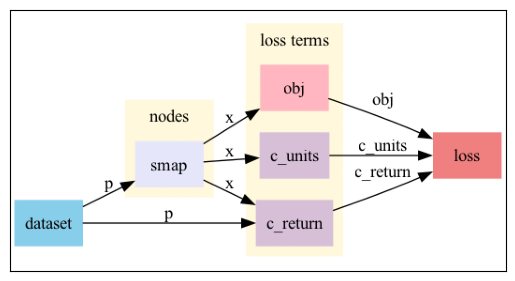

In [3]:
problem.show()

In [15]:
class LightningDataModule(pl.LightningDataModule): 
    def __init__(self,data_setup_function, batch_size, **kwargs): 
        super().__init__()
        self.data_setup_function = data_setup_function
        self.batch_size = batch_size 
        self.data_setup_kwargs = kwargs
        print(self.data_setup_kwargs)

        self.train_data = None 
        self.dev_data = None 
        self.test_data = None 

    def setup(self, stage=None): 
        train_data, dev_data, test_data = self.data_setup_function(**self.data_setup_kwargs)
        
        self.train_data = train_data
      
        self.dev_data = dev_data
     
        self.test_data = test_data
 
    def train_dataloader(self): 
        return DataLoader(self.train_data, batch_size=self.batch_size, collate_fn=self.train_data.collate_fn, device=self.device)
    
    def val_dataloader(self): 
        return DataLoader(self.dev_data, batch_size=self.batch_size, collate_fn=self.dev_data.collate_fn)
    def test_dataloader(self): 
        return DataLoader(self.test_data, batch_size=self.batch_size, collate_fn=self.dev_data.collate_fn)
    



class LitProblem(pl.LightningModule): 
    def __init__(self, problem, train_metric='train_loss', dev_metric='dev_loss', test_metric='test_loss', custom_optimizer=None): 
        super().__init__()
        self.problem = problem 
        self.train_metric = train_metric
        self.dev_metric = dev_metric
        self.test_metric = test_metric
        self.custom_optimizer = custom_optimizer
        self.training_step_outputs = []
        self.validation_step_outputs = []
    
    def training_step(self, batch): 
        output = self.problem(batch)
        loss = output[self.train_metric]
        self.training_step_outputs.append(loss)
        self.log('train_loss', loss, on_epoch=True, enable_graph=True, prog_bar=False)
        return loss 
    
    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_step_outputs).mean()
        print("EPOCH AVERAGE ", epoch_average)
        self.log("training_epoch_average", epoch_average)
        self.training_step_outputs.clear()  # free memory

    def on_validation_epoch_end(self):
        epoch_average = torch.stack(self.validation_step_outputs).mean()
        print("VAL EPOCH AVERAGE ", epoch_average)
        self.log("validation_epoch_average", epoch_average)
        self.validation_step_outputs.clear()  # free memory

    
    def validation_step(self, batch): 
        output = self.problem(batch)
        #assert self.dev_metric in output, f"Error: {self.dev_metric} not found in problem output"
        loss = output[self.dev_metric]
        self.validation_step_outputs.append(loss)
        self.log('dev_loss', loss)
    
    def configure_optimizers(self): 
        if self.custom_optimizer is None: 
            optimizer = torch.optim.Adam(self.problem.parameters(), 0.001, betas=(0.0, 0.9))
        else: 
            optimizer = self.custom_optimizer
        return optimizer 
    def get_problem(self): 
        return self.problem

class LightningTrainer(pl.Trainer):
    def __init__(self, *args,**kwargs):


        self.lit_problem = None 

        self.epochs = 1000
        self.train_metric = 'train_loss'
        self.dev_metric = 'dev_loss'
        self.test_metric = 'test_loss'
        self.eval_metric = 'dev_loss'
        self.patience = 5 
        self.warmup = 0 
        self.clip = 100.0

        self.setup_attributes(*args, **kwargs)

        self.model_checkpoint = ModelCheckpoint(
            save_weights_only=True,
            monitor=self.dev_metric,
            dirpath='./',
            mode='min',
            save_top_k=1, 
            verbose=True
        )

        super().__init__(max_epochs=self.epochs, callbacks=[self.model_checkpoint])

    def setup_attributes(self, *args, **kwargs): 
        if 'epochs' in kwargs:
            self.epochs = kwargs['epochs']
     
        if 'train_metric' in kwargs:
            self.train_metric = kwargs['train_metric']

        if 'dev_metric' in kwargs:
            self.dev_metric = kwargs['dev_metric']

        if 'test_metric' in kwargs:
            self.test_metric = kwargs['test_metric']

        if 'eval_metric' in kwargs:
            self.eval_metric = kwargs['eval_metric']

        if 'patience' in kwargs:
            self.patience = kwargs['patience']

        if 'warmup' in kwargs:
            self.warmup = kwargs['warmup']

        if 'clip' in kwargs:
            self.clip = kwargs['clip']

        if 'custom_optimizer' in kwargs: 
            self.custom_optimizer = kwargs['custom_optimizer']

    def get_weights(self):
        # Implement your custom method logic here
        best_model = self.lit_problem.state_dict()
        dev_loss_weights = self.model_checkpoint.best_model_path
        return dev_loss_weights
    
    def get_problem(self): 
        return self.lit_problem.problem

    def fit(self, problem, datamodule):

        if self.lit_problem is None: 
            self.lit_problem = LitProblem(problem,self.train_metric, self.dev_metric, self.test_metric, self.custom_optimizer )
        # Override the fit method if needed
        super().fit(self.lit_problem, datamodule)
        return self.get_weights()

In [16]:
lit_data_module = LightningDataModule(data_setup_function=data_setup_function, batch_size=batch_size,exp_returns=exp_returns)

lit_trainer = LightningTrainer(epochs=2, accelerator="auto", devices="auto", strategy="auto", custom_optimizer=optimizer, dev_metric='train_loss')
#best_problem_weights = lit_trainer.fit(problem, lit_data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


{'exp_returns': array([0.00364282, 0.00590949])}


In [17]:
best_problem_weights = lit_trainer.fit(problem, lit_data_module)

/Users/birm560/opt/anaconda3/envs/neuromancer2/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory ./ exists and is not empty.

  | Name    | Type    | Params
------------------------------------
0 | problem | Problem | 112   
------------------------------------
112       Trainable params
0         Non-trainable params
112       Total params
0.000     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 242.40it/s]VAL EPOCH AVERAGE  tensor(72.9652)
                                                                            

/Users/birm560/opt/anaconda3/envs/neuromancer2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/birm560/opt/anaconda3/envs/neuromancer2/lib/python3.10/site-packages/neuromancer/constraint.py:160: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


AttributeError: 'LightningDataModule' object has no attribute 'device'